In [1]:
import rebound
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
from matplotlib import animation
from matplotlib import colors as mcolors
from IPython.display import HTML, Image

class BlackHoleSimulation:
    g = 4*np.pi**2 
    units = ['Au', 'yr', 'Msun']
    
    #initialize Black Hole Class
    def __init__(self, starA, starB, semi = 1, blackhole = [100,0,100], phase = 0, binary_init_v = 10):
        self.sim = rebound.Simulation()
        self.sim.G = self.g 
        self.semi = semi
        self.phase = phase
        self.initial_v = binary_init_v
        self.sim.units = self.units
        self.sim.add(m=starA, a = semi)
        self.sim.add(m=starB)
        self.sim.add(m=blackhole[0], x= -1*blackhole[1],y= -1*blackhole[2])
        self.sim.particles[1].y += math.tan(phase*math.pi/180)*semi
        print("Star A:",self.sim.particles[0].x, self.sim.particles[0].y, "Star B:", self.sim.particles[1].x, self.sim.particles[1].y)
        self.sim.particles[0].vx=-0.210945021 * self.initial_v
        self.sim.particles[1].vx=-0.210945021 * self.initial_v
        self.sim.move_to_com()
        self.starA = self.sim.particles[0]
        self.starB = self.sim.particles[1]
        self.blackhole = self.sim.particles[2]
        #stores data on stars
        self.starA_x ,self.starA_y, self.starA_z = [],[],[]
        self.starB_x, self.starB_y, self.starB_z = [],[],[]
        self.starA_v, self.starA_a = [],[]
        self.starB_v, self.starB_a = [],[]
        
    #converts Au to Km/s 
    def unit_converter(self,unconverted, unit): 
        if unit == "AuToKms":
            converted = (unconverted * 4.74)
        elif unit == "AuToKms^2":
            converted = (unconverted * 1.50222861e-7)
        return converted
    
    #distance calculator
    def calculate_distance(self,star, blackhole):
        distance = np.sqrt(np.square(star.x - blackhole.x) + np.square(star.y - blackhole.y))
        return distance
    
    #integrate the simulation
    def run_simulation(self, endtime, outputs):
        times = np.linspace(0,endtime,outputs) #(start,finish, number of data points)
        self.timeList = times.tolist() 
        self.outputs = outputs
        self.endtime = endtime
        for i,times in enumerate(times): #integrate simulation 
            self.starA_x.append(self.starA.x)
            self.starA_y.append(self.starA.y) 
            self.starA_z.append(self.starA.z) 
            self.starB_x.append(self.starB.x)
            self.starB_y.append(self.starB.y)
            self.starB_z.append(self.starA.z)
            self.starA_v.append(self.unit_converter(((self.starA.vx**2) + (self.starA.vy**2) + (self.starA.vz**2))**(.5),"AuToKms"))
            self.starB_v.append(self.unit_converter(((self.starB.vx**2) + (self.starB.vy**2) + (self.starB.vz**2))**(.5),"AuToKms"))
            self.starA_a.append(self.unit_converter(((self.starA.ax**2) + (self.starA.ay**2) + (self.starA.az**2))**(.5),"AuToKms^2"))
            self.starB_a.append(self.unit_converter(((self.starB.ax**2) + (self.starB.ay**2) + (self.starB.az**2))**(.5),"AuToKms^2"))
            self.sim.integrate(times)

    #returns maximum velocities of stars
    def get_velocity(self,command):
        if command == "i":
            return "Star A initial velocity: ", self.starA_v[0], "Star B initial velocity: ", self.starB_v[0]
        elif command == "f":
            return "Star A final velocity: ", self.starA_v[self.outputs-1], "Star B final velocity: ", self.starB_v[self.outputs-1]
        elif command == "max":
            return "Star A max velocity: ", max(self.starA_v), "Star B max velocity: ", max(self.starB_v)
        else:
            return "Please enter valid command(i,f,max)"
    
    #plots a x vs. y position graph for both stars
    def get_position_graph(self):
        #star A 
        plt.subplot(2,2,1)
        plt.plot(self.starA_x,self.starA_y)
        plt.plot(self.blackhole.x,self.blackhole.y,'b.')
        plt.title("Position of Star A")
        plt.xlabel("X-position(Au)")
        plt.ylabel("Y-position(Au)")

        #star B
        plt.subplot(2,2,2)
        plt.plot(self.starB_x,self.starB_y)
        plt.plot(self.blackhole.x,self.blackhole.y,'b.')
        plt.title("Position of Star B")
        plt.xlabel("X-position(Au)")
        plt.ylabel("Y-position(Au)")
        plt.tight_layout()
        plt.show()
    
    #creates scatter plot. Takes the min and max of each axis.
    def create_scatter(self, xmin, xmax, ymin, ymax):
        fig = plt.figure()
        ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin, ymax))#set axis
        plt.plot(self.starA_x,self.starA_y)#plot star a
        plt.plot(self.starB_x,self.starB_y)#plot star b
        plt.plot(self.blackhole.x,self.blackhole.y,'b.')#plot black hole
        plt.xlabel("X-pos(Au)")
        plt.ylabel("Y-pos(Au)")
        plt.show()
        
        fig.savefig("BH" + str(self.sim.particles[2].m) + "_Bi" + str(self.sim.particles[0].m)+"_a"+ str(self.semi) +"_p" + str(self.phase) +"_v" + str(self.initial_v) + ".png")

    #creates csv file for data points collected
    def create_CSV(self):
        with open("BH" + str(self.sim.particles[2].m) + "_Bi" + str(self.sim.particles[0].m)+"_a"+ str(self.semi) +"_p" + str(self.phase) + "_v" + str(self.initial_v) +".csv", 'w', newline='') as csvfile:
            fieldnames = ['Star A X-pos(AU)', 'Star A Y-pos(AU)','Star B X-pos(AU)', 'Star B Y-pos(AU)', 'Star A Velocity(Km/s)','Star B Velocity(Km/s)', 'Star A Acceleration(Km/s^2)', 'Star B Acceleration(Km/s^2)', 'time(yr)']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(0,self.outputs):
                 writer.writerow({'Star A X-pos(AU)': str(self.starA_x[i]), 'Star A Y-pos(AU)': str(self.starA_y[i]), 'Star B X-pos(AU)': str(self.starB_x[i]), 'Star B Y-pos(AU)': str(self.starB_y[i]), 'Star A Velocity(Km/s)': str(self.starA_v[i]), 'Star B Velocity(Km/s)': str(self.starB_v[i]),'Star A Acceleration(Km/s^2)': str(self.starA_a[i]), 'Star B Acceleration(Km/s^2)': str(self.starB_a[i]), 'time(yr)': str(self.timeList[i])})    
    
    #creates animation. Specify start and end of animation
    def animate_simulation(self, start, end, axis, title="Animation", fps=60, option=0):
        fig = plt.figure()
        ax = plt.axes(xlim=(axis[0], axis[1]), ylim=(axis[2], axis[3]))
        graph = plt.scatter([], [], s=2)
        graph2 = plt.scatter([], [], s=2)
        graph.set_facecolors('b')
        graph2.set_facecolors('r')
        time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)
        starA_v_text = ax.text(0.1,0.85,'',transform=ax.transAxes)
        starB_v_text = ax.text(0.1,0.80,'',transform=ax.transAxes)
        plt.plot(self.blackhole.x,self.blackhole.y,'b.')
        plt.title("Black Hole and Binary Star System", bbox={'facecolor':'blue', 'alpha':0.3, 'pad':10})
        plt.xlabel("X-position(Au)")
        plt.ylabel("Y-position(Au)")
        totalFrames = int(self.outputs*((end-start)/self.endtime))
        startFrame = int(self.outputs/self.endtime*start)
        print("total frames: ", totalFrames, "start frame: ",startFrame)
        
        # animation function.  This is called sequentially
        def animate(i):
            #plt.plot(self.starA_x[startFrame:i+startFrame],self.starA_y[startFrame:i+startFrame])
            #plt.plot(self.starB_x[startFrame:i+startFrame],self.starB_y[startFrame:i+startFrame])
            time_text.set_text('Time(yr): ' + str(int(self.timeList[i+startFrame])))
            starA_v_text.set_text('Star A Velocity: ' + str(int(self.starA_v[i+startFrame])) + ' km/s')
            starB_v_text.set_text('Star B Velocity: ' + str(int(self.starB_v[i+startFrame])) + ' km/s')
            if option == 0:
                graph.set_offsets(np.vstack((self.starA_x[startFrame:i+startFrame], self.starA_y[startFrame:i+startFrame])).T)
                graph2.set_offsets(np.vstack((self.starB_x[startFrame:i+startFrame], self.starB_y[startFrame:i+startFrame])).T)
            elif option == 1:
                plt.plot(self.starA_x[0:i*10],self.starA_y[0:i*10])
                plt.plot(self.starB_x[0:i*10],self.starB_y[0:i*10])
            return graph,
        
        # call the animator
        anim = animation.FuncAnimation(fig, animate, frames=totalFrames, interval=20, blit=True)
        anim.save(title+'.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
        HTML(anim.to_html5_video())
        

In [50]:
sim = BlackHoleSimulation(.1,.1,semi = .01, blackhole = [100,0,100], phase = 30, binary_init_v=15) #(Star A mass, Star B mass, Semi, black hole[mass,x,y])

Star A: 0.01 0.0 Star B: 0.0 0.005773502691896256


In [51]:
%time sim.run_simulation(50,25000)

CPU times: user 30min 16s, sys: 16 s, total: 30min 32s
Wall time: 31min 38s


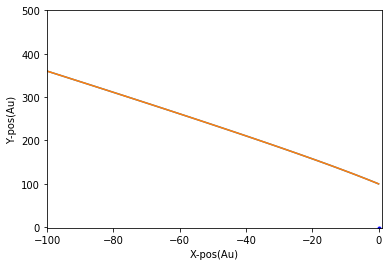

In [52]:
sim.create_scatter(-100,1,-1.5,500)

In [53]:
sim.create_CSV()

In [23]:
sim.get_velocity("f")

('Star A final velocity: ',
 72.77832879742856,
 'Star B final velocity: ',
 66.68495435562421)

In [ ]:
ansSet= False

inputs = []

def get_input():
    A_mass = input("Star A Mass(Msun): ")
    B_mass = input("Star B Mass(Msun): ")
    Semi = input("Semi-Major Axis(Au): ")
    bh_mass = input("Black Hole Mass(Msun): ")
    bh_pos = input("Initial Coordinates of Binary System(x,y): ")
    #starA = [float(A_info[0:A_info.find(",")]), float(A_info[A_info.find(",")+1:])]
    #starB = [float(B_info[0:B_info.find(",")]), float(B_info[B_info.find(",")+1:])]
    blackhole = [float(bh_mass), float(bh_pos[0:bh_pos.find(",")]), float(bh_pos[bh_pos.find(",")+1:])]
    inputs.append(float(A_mass))
    inputs.append(float(B_mass))
    inputs.append(float(Semi))
    inputs.append(blackhole)
    return True 

In [ ]:
ans = input("Would you like rewrite the previous parameters entered?(y/n): ")

if(ans == "y"):
    ansSet = get_input()
    
elif(ans == "n" and ansSet == False):
    print("You have not entered any parameters")
    while(ansSet == False):
        ansSet = getInput()
sim = BlackHoleSimulation(inputs[0],inputs[1],inputs[2],inputs[3]) #(Star A mass, Star B mass, Semi, black hole[mass,x,y])